In [1]:
from astropy.io import fits
from scipy.interpolate import interp1d,interp2d
from yattag import Doc
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import seaborn as sea
import os
from time import time
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, 
                             light=1.2, as_cmap=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [12]:
class Stack_galaxy(object):
    def __init__(self, file_list):
        self.file_list = file_list

    def Get_spec(self, FILE):
        observ = fits.open(FILE)
        w = np.array(observ[1].data.field('wave'))
        f = np.array(observ[1].data.field('flux')) * 1E-17
        sens = np.array(observ[1].data.field('sensitivity'))
        contam = np.array(observ[1].data.field('contam')) * 1E-17
        e = np.array(observ[1].data.field('error')) * 1E-17
        f -= contam
        f /= sens
        e /= sens

        INDEX = []
        for i in range(len(w)):
            if 8000 < w[i] < 11350:
                INDEX.append(i)

        w = w[INDEX]
        f = f[INDEX]
        e = e[INDEX]

        return w, f, e

    def Get_wv_list(self):
        W = []
        lW = []

        for i in range(len(self.file_list)):
            wv, fl, er = self.Get_spec(self.file_list[i])
            W.append(wv)
            lW.append(len(wv))

        W = np.array(W)
        self.wv = W[np.argmax(lW)]

    def Mean_stack_galaxy(self):

        self.Get_wv_list()
        
        # Define grids used for stacking
        flgrid = np.zeros([len(self.file_list), len(self.wv)])
        errgrid = np.zeros([len(self.file_list), len(self.wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(self.file_list)):
            wave, flux, error = self.Get_spec(self.file_list[i])
            
            if len(wave) > 10:
            
                mask = np.array([wave[0] < U < wave[-1] for U in self.wv])
                ifl = interp1d(wave, flux)(self.wv[mask])
                ier = interp1d(wave, error)(self.wv[mask])


                flgrid[i][mask] = ifl
                errgrid[i][mask] = ier

        ################

        flgrid = np.transpose(flgrid)
        errgrid = np.transpose(errgrid)
        weigrid = errgrid ** (-2)
        infmask = np.isinf(weigrid)
        weigrid[infmask] = 0
        ################

        stack, err = np.zeros([2, len(self.wv)])
        for i in range(len(self.wv)):
            stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
            err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
        ################

        self.fl = np.array(stack)
        self.er = np.array(err)
        
        self.wv = self.wv[self.fl>0]
        self.er = self.er[self.fl>0]
        self.fl = self.fl[self.fl>0]

In [3]:
def Get_flux(FILE):
    observ = fits.open(FILE)
    w = np.array(observ[1].data.field('wave'))
    f = np.array(observ[1].data.field('flux')) * 1E-17
    sens = np.array(observ[1].data.field('sensitivity'))
    contam = np.array(observ[1].data.field('contam')) * 1E-17
    e = np.array(observ[1].data.field('error')) * 1E-17
    f -= contam
    f /= sens
    e /= sens

    INDEX = []
    for i in range(len(w)):
        if 8000 < w[i] < 11350:# and e[i] < np.abs(f[i]):
            INDEX.append(i)

            
            
    w = w[INDEX]
    f = f[INDEX]
    e = e[INDEX]

#     return w[f > 0], f[f > 0], e[f > 0]
    return w, f, e

In [4]:
SDF = pd.read_pickle('south_DF.pkl')
NDF = pd.read_pickle('north_DF.pkl')

In [15]:
SDF[SDF.id == 39116]

,1D,2D,id,2D_all
890,/Volumes/Vince_homedrive/Extractions/clear-19/...,/Volumes/Vince_homedrive/Extractions/clear-19/...,39116,/Volumes/Vince_homedrive/Extractions/COMBINED/...


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in power
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in greater
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in greater
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in greater


(0.8, 1.14)

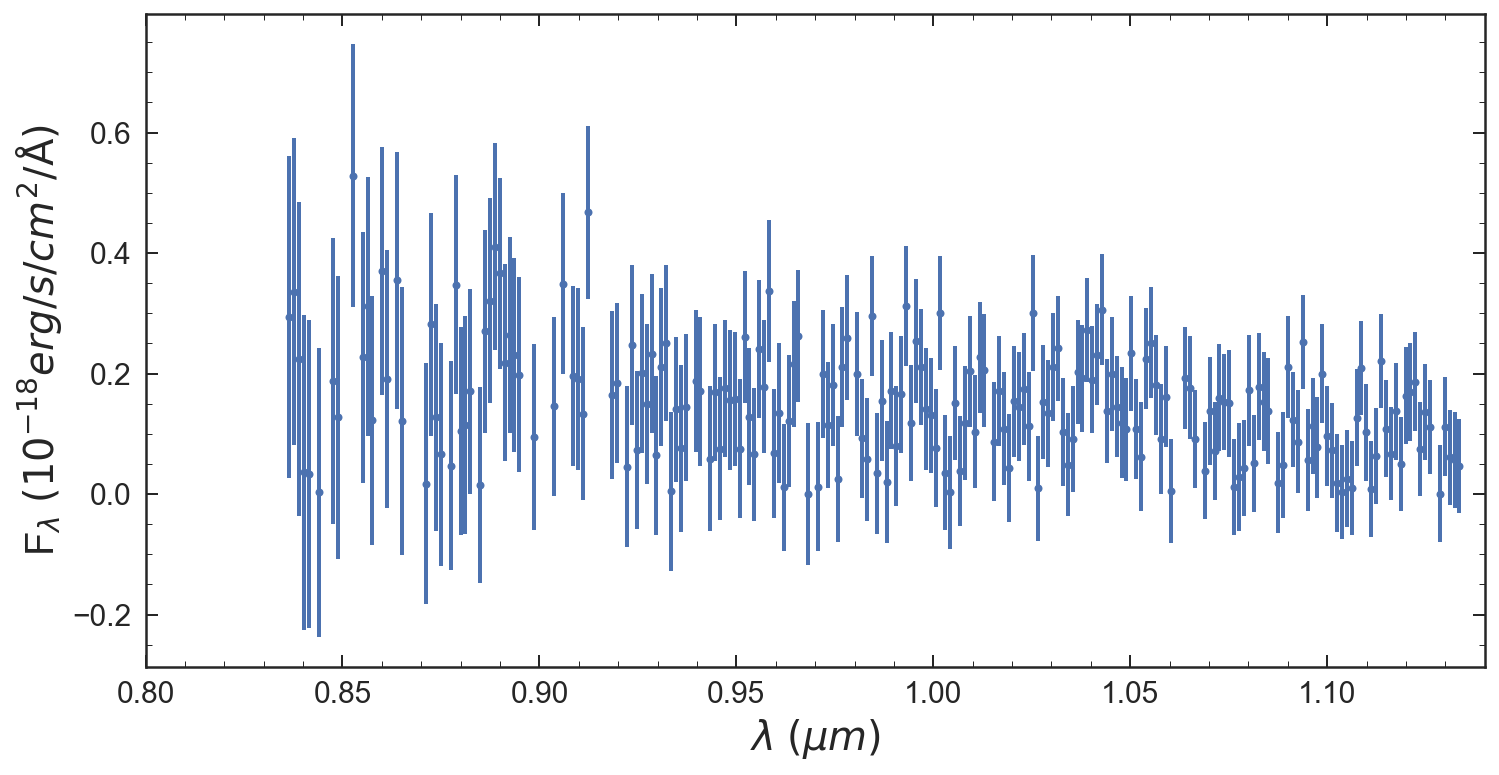

In [16]:
file_list = SDF['1D'][890].split(',')[:-1]
stack = Stack_galaxy(file_list)
stack.Mean_stack_galaxy()

# for i in range(len(file_list)):
#     name = file_list[i].split('/')[-1].split('_')[0]
    
#     wv,fl,er = Get_flux(file_list[i])
    
#     IDX = [U for U in range(len(wv)) if er[U] < 2*np.median(fl)]
        
#     plt.figure(figsize=[12,6])
#     plt.errorbar(wv[IDX]*1E-4,fl[IDX]*1E18,er[IDX]*1E18,fmt='o',lw=2,ms=4)
#     plt.xlabel('$\lambda$ $(\mu m)$',fontsize=20)
#     plt.ylabel('F$_\lambda$ $(10^{-18} erg/ s/ cm^{2}/ \\rm \AA)$',fontsize=20)
#     plt.tick_params(axis='both', which='major', labelsize=15)
#     plt.title('%s_%s' % (name,SDF['id'][250]),fontsize=20)
#     plt.xlim(.8,1.14)
  
IDX = [U for U in range(len(stack.wv)) if stack.er[U] < 2*np.median(stack.fl)]
plt.figure(figsize=[12,6])
plt.errorbar(stack.wv[IDX]*1E-4,stack.fl[IDX]*1E18,stack.er[IDX]*1E18,fmt='o',lw=2,ms=4)
plt.xlabel('$\lambda$ $(\mu m)$',fontsize=20)
plt.ylabel('F$_\lambda$ $(10^{-18} erg/ s/ cm^{2}/ \\rm \AA)$',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(.8,1.14)


In [8]:
def Plot_1d(DF,idx, position):
    if os.path.isfile('/Volumes/Vince_homedrive/Extractions/Plots/%s/1D/stack/%s_stack.png' % (position, DF['id'][idx])):
        dummy = 1
    else:
        if len(DF['1D'][idx]) > 0:
            file_list = DF['1D'][idx].split(',')[:-1]
            viable = False
            
            for u in range(len(file_list)):
                name = file_list[u].split('/')[-1].split('_')[0]

                wv,fl,er = Get_flux(file_list[u])
                
                if len(wv) > 10:
                    viable = True
                
                IDX = [U for U in range(len(wv)) if er[U] < 2*np.median(fl)]

                plt.figure(figsize=[12,6])
                plt.errorbar(wv[IDX]*1E-4,fl[IDX]*1E18,er[IDX]*1E18,fmt='o',lw=2,ms=4)
                plt.xlabel('$\lambda$ $(\mu m)$',fontsize=20)
                plt.ylabel('F$_\lambda$ $(10^{-18} erg/ s/ cm^{2}/ \\rm \AA)$',fontsize=20)
                plt.tick_params(axis='both', which='major', labelsize=15)
                plt.title('%s_%s' % (name,SDF['id'][idx]),fontsize=20)
                plt.xlim(.8,1.14)
                plt.savefig('/Volumes/Vince_homedrive/Extractions/Plots/%s/1D/spec/%s_%s_spec.png' % (position, name, DF['id'][idx]))    
                plt.close()
            
            if viable == True:
            
                stack = Stack_galaxy(file_list)
                stack.Mean_stack_galaxy()

                IDX = [U for U in range(len(stack.wv)) if stack.er[U] < 2*np.median(stack.fl)]

                plt.figure(figsize=[12,6])
                plt.errorbar(stack.wv[IDX]*1E-4,stack.fl[IDX]*1E18,stack.er[IDX]*1E18,fmt='o',lw=2,ms=4)
                plt.xlabel('$\lambda$ $(\mu m)$',fontsize=20)
                plt.ylabel('F$_\lambda$ $(10^{-18} erg/ s/ cm^{2}/ \\rm \AA)$',fontsize=20)
                plt.tick_params(axis='both', which='major', labelsize=15)
                plt.xlim(.8,1.14)
                plt.savefig('/Volumes/Vince_homedrive/Extractions/Plots/%s/1D/stack/%s_stack.png' % (position, DF['id'][idx]))
                plt.close()

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in power
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


KeyboardInterrupt: 

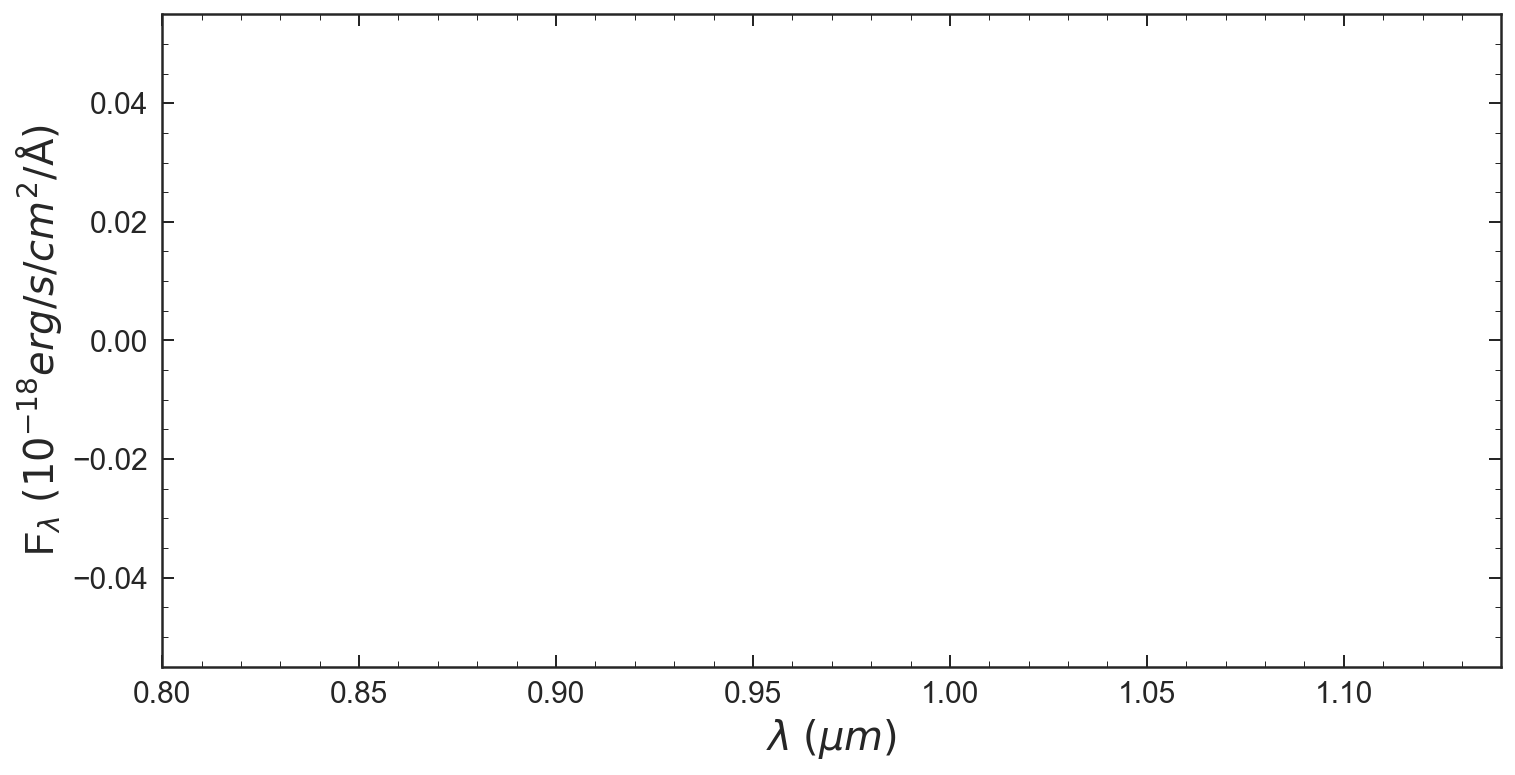

In [9]:
for i in SDF.index:
    Plot_1d(SDF,i,'South')

for i in NDF.index:
    Plot_1d(NDF,i,'North')

In [184]:
class Stack_galaxy_test(object):
    def __init__(self, file_list):
        self.file_list = file_list

    def Get_spec(self, FILE):
        observ = fits.open(FILE)
        w = np.array(observ[1].data.field('wave'))
        f = np.array(observ[1].data.field('flux')) * 1E-17
#         sens = np.array(observ[1].data.field('sensitivity'))
#         contam = np.array(observ[1].data.field('contam')) * 1E-17
        e = np.array(observ[1].data.field('error')) * 1E-17
#         f -= contam
#         f /= sens
#         e /= sens

        INDEX = []
        for i in range(len(w)):
            if 8000 < w[i] < 11350:
                INDEX.append(i)

        w = w[INDEX]
        f = f[INDEX]
        e = e[INDEX]

        return w, f, e

    def Get_wv_list(self):
        W = []
        lW = []

        for i in range(len(self.file_list)):
            wv, fl, er = self.Get_spec(self.file_list[i])
            W.append(wv)
            lW.append(len(wv))

        W = np.array(W)
        self.wv = W[np.argmax(lW)]

    def Mean_stack_galaxy(self):

        self.Get_wv_list()
        
        # Define grids used for stacking
        flgrid = np.zeros([len(self.file_list), len(self.wv)])
        errgrid = np.zeros([len(self.file_list), len(self.wv)])

        # Get wv,fl,er for each spectra
        for i in range(len(self.file_list)):
            wave, flux, error = self.Get_spec(self.file_list[i])
            
            if len(wave) > 10:
            
                mask = np.array([wave[0] < U < wave[-1] for U in self.wv])
                ifl = interp1d(wave, flux)(self.wv[mask])
#                 ier = interp1d(wave, error)(self.wv[mask])


#                 flgrid[i][mask] = ifl
#                 errgrid[i][mask] = ier

#         ################

#         flgrid = np.transpose(flgrid)
#         errgrid = np.transpose(errgrid)
#         weigrid = errgrid ** (-2)
#         infmask = np.isinf(weigrid)
#         weigrid[infmask] = 0
#         ################

#         stack, err = np.zeros([2, len(self.wv)])
#         for i in range(len(self.wv)):
#             stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
#             err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
#         ################

#         self.fl = np.array(stack)
#         self.er = np.array(err)

In [187]:
def TEST(DF,idx, position):
    if os.path.isfile('/Volumes/Vince_homedrive/Extractions/Plots/%s/1D/stack/%s_stack.png' % (position, DF['id'][idx])):
#         print 'skipped'
        dummy=1

    else:
        print idx
        if len(DF['1D'][idx]) > 0:
            file_list = DF['1D'][idx].split(',')[:-1]
            viable = False
            
            for u in range(len(file_list)):
                name = file_list[u].split('/')[-1].split('_')[0]

                wv,fl,er = Get_flux(file_list[u])
                
                if len(wv) > 10:
                    viable = True
                    
            if viable == True:
                stack = Stack_galaxy_test(file_list)
                stack.Mean_stack_galaxy()

#             for u in range(len(file_list)):
#                 name = file_list[u].split('/')[-1].split('_')[0]

#                 wv,fl,er = Get_flux(file_list[u])

#                 plt.figure(figsize=[12,6])
#                 plt.errorbar(wv*1E-4,fl*1E18,er*1E18,fmt='o',lw=2,ms=4)
#                 plt.xlabel('$\lambda$ $(\mu m)$',fontsize=20)
#                 plt.ylabel('F$_\lambda$ $(10^{-18} erg/ s/ cm^{2}/ \\rm \AA)$',fontsize=20)
#                 plt.tick_params(axis='both', which='major', labelsize=15)
#                 plt.title('%s_%s' % (name,SDF['id'][idx]),fontsize=20)
#                 plt.xlim(.8,1.14)
#                 plt.savefig('/Volumes/Vince_homedrive/Extractions/Plots/%s/1D/spec/%s_%s_spec.png' % (position, name, DF['id'][idx]))    
#                 plt.close()

#             plt.figure(figsize=[12,6])
#             plt.errorbar(stack.wv*1E-4,stack.fl*1E18,stack.er*1E18,fmt='o',lw=2,ms=4)
#             plt.xlabel('$\lambda$ $(\mu m)$',fontsize=20)
#             plt.ylabel('F$_\lambda$ $(10^{-18} erg/ s/ cm^{2}/ \\rm \AA)$',fontsize=20)
#             plt.tick_params(axis='both', which='major', labelsize=15)
#             plt.xlim(.8,1.14)
#             plt.savefig('/Volumes/Vince_homedrive/Extractions/Plots/%s/1D/stacks/%s_stack.png' % (position, DF['id'][idx]))
#             plt.close()

In [192]:
for i in SDF.index:
    TEST(SDF,i,'South')

# for i in NDF.index:
#     TEST(NDF,i,'North')

252
383
410
438
439
440
443
444
445
446
453
454
455
456
458
460
466
468
472
501
514
521
533
541
585
610
616
631
691
712
771


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


1020
1021
1022
1023
1024
1025
1026
1027
1028


KeyboardInterrupt: 

In [164]:
SDF['1D'][533]

'/Volumes/Vince_homedrive/Extractions/clear-17/1D/FITS/GS5-17-215-G102_35205.1D.fits,/Volumes/Vince_homedrive/Extractions/clear-18/1D/FITS/GS5-18-215-G102_35205.1D.fits,'

In [191]:
start  = time()

for i in range(1000):
    print i 
end = time()
print end - start
  
    
start  = time()
IDX=np.zeros(1000)
  
for i in range(1000):

    IDX[i] = i
#     np.save('ids',IDX)
end = time()
print end - start

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27